# Introduction to diffpy.mpdf

For further information and tutorial resources, please visit https://github.com/FrandsenGroup/diffpy.mpdf .

# Contents of this tutorial

- Class structure of the mpdf package
- Simple example: Calculating the mPDF from a spin dimer
- Creating a magnetic structure from a CIF file using diffpy.Structure
- Creating a magnetic structure from an MCIF file
- Creating a magnetic structure by defining your own unit cell
- Creating a magnetic structure with multiple species: Simple ferrimagnet
- Creating more complex magnetic structures: One-dimensional spin helix
- Playing with some calculation parameters


# Class structure of the mpdf package

The core classes in the mpdf package the MPDFcalculator class, the MagStructure class, and the optional (but often very useful) MagSpecies class. There are also numerous other functions and classes to aid in mPDF calculations, many of which we will introduce here.

### MagStructure class

The main job of a MagStructure object is to contain a numpy array of atomic positions (MagStructure.atoms) and a corresponding numpy array of magnetic moment vectors (MagStructure.spins), which are the only two absolutely required ingredients for calculating the mPDF. Additional optional information such as the Lande g-factor or magnetic form factor can be stored in a MagStructure object if it is needed (as it often is for performing mPDF refinements). A diffpy.structure object corresponding to the atomic structure of the material can also be stored for convenience when generating the atomic positions and spin vectors. Multiple types of magnetic species (e.g. spins on different ionic sites that may have different moment sizes) can be stored inside a single MagStructure object.

### MagSpecies class

The MagSpecies class is intended to provide an easy way to generate the atomic positions and spin vectors of a particular type of magnetic species in a structure. It takes a diffpy.structure object and packages additional information pertaining to the magnetic structure, such as the magnetic propagation vector(s), magnetic basis vector(s), spin/orbital quantum numbers, and magnetic form factor. Alternatively, the user can define a unit cell populated with positions and spin orientations of the magnetic atoms, and this will be used rather than a diffpy.structure object. The structural information is used in class methods that automatically generate the atomic positions and corresponding spin vectors, which can then be stored in a MagStructure object. There are no limits on the number of propagation and basis vectors, allowing for arbitrarily complex magnetic structures. MagSpecies objects can be loaded directly into a MagStructure object or created from inside the MagStructure object. Although a MagSpecies object is not required to calculate the mPDF, it will usually provide the easiest way to populate the atom and spin arrays that are required for the mPDF. The reason for having separate MagStructure and MagSpecies classes is that a single magnetic structure may contain multiple magnetic species.

### MPDFcalculator class

The MPDFcalculator class handles the details of the calculation and contains information that is not directly related to the magnetic structure, such as the real-space calculation range, instrumental resolution effects, scale factors, and experimental parameters like q<sub>min</sub> and q<sub>max</sub>. It requires a MagStructure object as input, from which it extracts the atomic positions and spin vectors to be used in calculating the mPDF. The mPDFcalculator class has options for calculating both the properly normalized and the unnormalized mPDF (the unnormalized mPDF is frequently what we obtain experimentally).

## Simple example: Calculating the mPDF from a pair of spins

We will now create a very simple magnetic structure consisting of just two spins and then calculate the corresponding mPDF.

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.structure import loadStructure

### Set all plots to be inline
%matplotlib notebook

# Note: I often have to run this cell twice to get the
# matplotlib plots to display in interactive mode

<IPython.core.display.Javascript object>


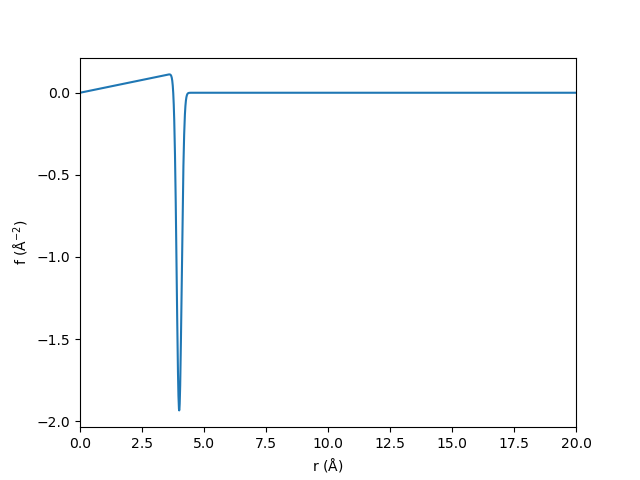

In [3]:
### Create a MagStructure object
mstruc = MagStructure()

### Create two atoms in the structure
mstruc.atoms = np.array([[0,0,0],[4,0,0]])

### Create two spin vectors corresponding to the atoms. Let's make them antiferromagnetic.
S=np.array([0,0,1])
mstruc.spins = np.array([S,-S])

### Create the MPDFcalculator object and load the magnetic structure into it
mc = MPDFcalculator(mstruc)

### Calculate and plot the mPDF!
r,fr = mc.calc() # Use calc() if you want to extract the numerical results of the calculation
mc.plot() # Use plot() if you just want to plot the mPDF without extracting the numerical arrays.

Note that the peak is located at 4 A (the separation distance between the spins) and is negative due to the antiferromagnetic alignment.

Now let's make a copy of this structure but make the dimer ferromagnetic instead of antiferromagnetic.

<IPython.core.display.Javascript object>


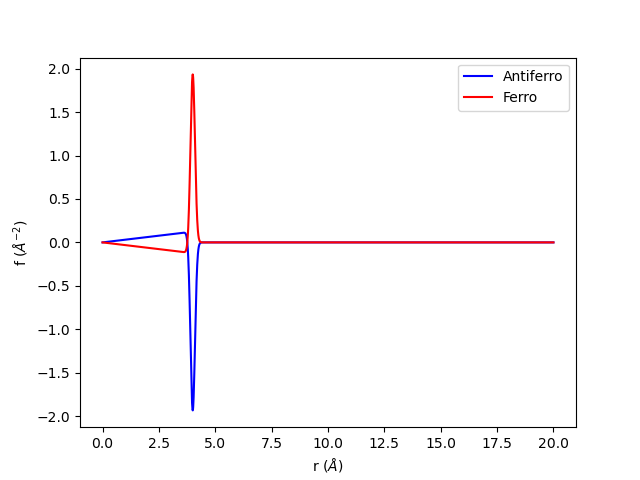

In [4]:
### make a copy of the magnetic structure
mstruc2 = mstruc.copy()

### Set the spins to be ferromagnetic
mstruc2.spins = np.array([S,S])

### Create another mPDF calculator
mc2 = MPDFcalculator(mstruc2)

### Calculate the mPDF
r2, fr2 = mc2.calc()

### Compare the antiferromagnetic and ferromagnetic mPDFs
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r,fr,'b-',label='Antiferro')
ax.plot(r2,fr2,'r-',label='Ferro')

ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend()

plt.show()

In [5]:
plt.close('all')

## Creating a magnetic structure from a CIF file using diffpy.structure

This example will show how to use the MagSpecies class and additional features in the MagStructure class to quickly generate the atomic positions and spin vectors from a diffpy.Structure object. It will also show how to calculate the unnormalized mPDF, which is useful for comparison to and refinement against neutron total scattering data.

### Load the atomic structure from the CIF file

In [6]:
### Now let's create a diffpy.Structure object from a CIF file for MnO. This has all the atomic information,
### but none of the magnetic information. Note that a .stru file generated from PDFgui or diffpy.Structure
### would also work just as well.
mno = loadStructure('MnO_cubic.cif')

In [7]:
### As a refresher, let's take a look at the mno structure object.
print(mno)

lattice=Lattice(a=4.446, b=4.446, c=4.446, alpha=90, beta=90, gamma=90)
Mn2+ 0.000000 0.000000 0.000000 1.0000
Mn2+ 0.000000 0.500000 0.500000 1.0000
Mn2+ 0.500000 0.000000 0.500000 1.0000
Mn2+ 0.500000 0.500000 0.000000 1.0000
O2-  0.500000 0.500000 0.500000 1.0000
O2-  0.500000 0.000000 0.000000 1.0000
O2-  0.000000 0.500000 0.000000 1.0000
O2-  0.000000 0.000000 0.500000 1.0000


### Create the MagSpecies object

In [8]:
### We will now create a MagSpecies object to extend the mno structure object.
mspec = MagSpecies()

### Load the mno structure and give the magnetic species a label
mspec.struc = mno
mspec.label = 'Mn2+'

### Now we need to tell it which atoms in MnO are magnetic. From the printed list in the previous cell,
### the magnetic Mn ions are the first four positions in the structure, so we provide the corresponding indices.
mspec.strucIdxs = [0,1,2,3]

### Now we provide the magnetic propagation and basis vectors, which are known from previous neutron
### diffraction studies of MnO.
k = np.array([0.5,0.5,0.5])
s = np.array([1,-1,0]) # we won't worry about the magnitude of the basis vector for now
mspec.kvecs = np.array([k])
mspec.basisvecs = np.array([s])
### Below, we specify the origin relative to which the propagation vectors are defined.
### It should always correspond to the Cartesian coordinates of the position of one of
### the spins in the structure. By default it is zero, so the line below isn't necessary
### in this particular case, but we show it just for demonstrative purposes.
mspec.origin = np.array([0,0,0])

### Now we provide information about the magnetic form factor. We tell the MagSpecies object the type of magnetic
### ion, and it looks up magnetic form factor in a table.
mspec.ffparamkey = 'Mn2'

### Create the MagStructure object

In [9]:
### Now we can create a MagStructure object and load mnoMag into it.
mstruc = MagStructure()
mstruc.loadSpecies(mspec)
### Now we will generate the atomic positions and spins. It is important to do the atoms first, since the
### spins are generated by applying the propagation and basis vectors to the atomic positions. These methods
### use the information contained in the atomic and magnetic structures to generate arrays of atomic positions
### and spin vectors.
mstruc.makeAtoms()
mstruc.makeSpins()

### And we make the magnetic form factor:
mstruc.makeFF()

### View the magnetic structure

<IPython.core.display.Javascript object>


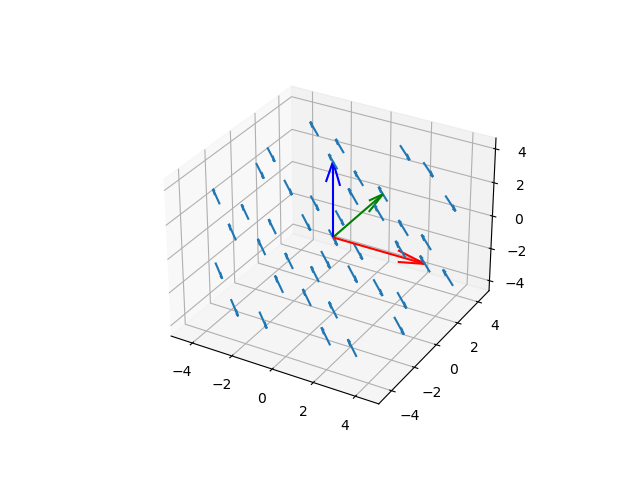

In [10]:
### diffpy.mpdf includes a very rudimentary magnetic structure viewer
### which can be useful at times. Let's visualize all the spins found
### within 6 Angstroms of the origin.
distances = np.apply_along_axis(np.linalg.norm, 1, mstruc.atoms)
viewmask = distances < 6
mstruc.visualize(mstruc.atoms[viewmask], mstruc.spins[viewmask], showcrystalaxes=True)

<IPython.core.display.Javascript object>


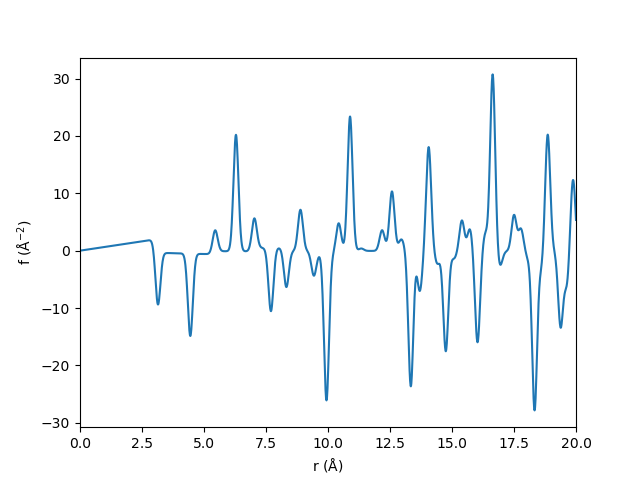

In [11]:
### Now we can create the mPDF calculator and load the magnetic structure
mc = MPDFcalculator()
mc.magstruc = mstruc

### Plot the mPDF
mc.plot()

In [12]:
plt.close('all')

# Creating a magnetic structure from an MCIF file

If you have an MCIF file available (see, for example, the database at http://webbdcrista1.ehu.es/magndata/ ), then you can create a MagStructure object with just one line of code.

MagStructure creation from mcif file successful.


<IPython.core.display.Javascript object>


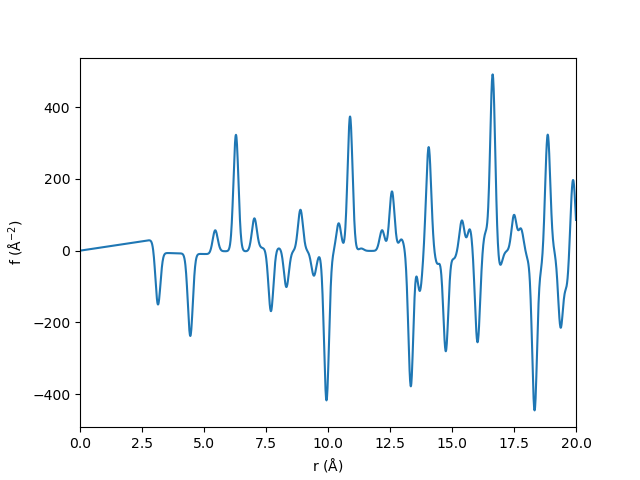

In [13]:
mcif = '1.31_MnO.mcif'
mstruc = create_from_mcif(mcif, ffparamkey='Mn2')
mstruc.makeAll()

mc = MPDFcalculator(mstruc)

mc.plot()

In [14]:
plt.close('all')

# Creating a magnetic structure by defining your own unit cell

This example will show you how to create a magnetic structure from a unit cell that you define yourself. You will have to provide the lattice vectors, the positions of the magnetic atoms in the unit cell, and the magnetic moments corresponding to those atoms.

Since you are not using a diffpy Structure object,
the spins are generated from the makeAtoms() method.
Please call that method if you have not already.


<IPython.core.display.Javascript object>


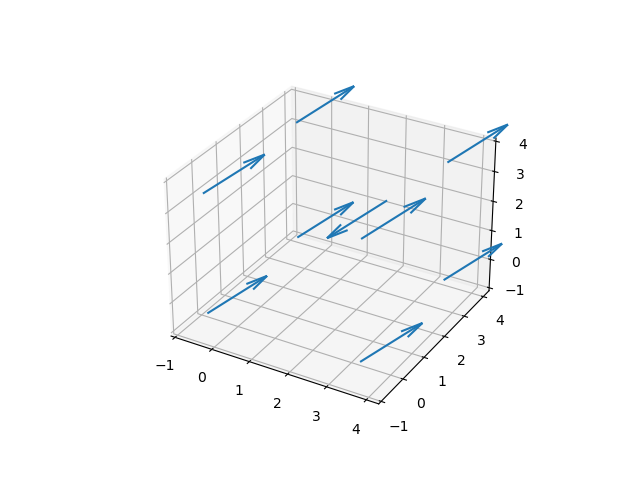

In [15]:
### Create the magnetic species and turn off the diffpy.structure option.
mspec = MagSpecies(useDiffpyStruc=False)

### Define the lattice vectors of the unit cell. Let's make a cubic unit cell.
a = 4.0
mspec.latVecs = np.array([[a,0,0], [0,a,0], [0,0,a]])

### Define the positions of the magnetic atoms in the unit cell (in fractional coordinates). Let's make
### We'll make a body-centered structure.
mspec.atomBasis = np.array([[0,0,0], [0.5,0.5,0.5]])

### Define the magnetic moments in the same order as the list of atoms.
### Let's make an antiferromagnet.
mspec.spinBasis = np.array([[1,1,1], [-1,-1,-1]])


### Create the magnetic structure object and load mspec.
mstruc = MagStructure()
mstruc.loadSpecies(mspec)
mstruc.makeAtoms()
mstruc.makeSpins()

### Let's visualize the first unit cell to make sure we have what we expect.
visAtoms = np.array([[0,0,0],[a,0,0],[0,a,0],[0,0,a],[a,a,0],
                     [a,0,a],[0,a,a],[a,a,a],[0.5*a,0.5*a,0.5*a]])
visSpins = mstruc.spinsFromAtoms(visAtoms, fractional=False)
mstruc.visualize(visAtoms, visSpins)

<IPython.core.display.Javascript object>


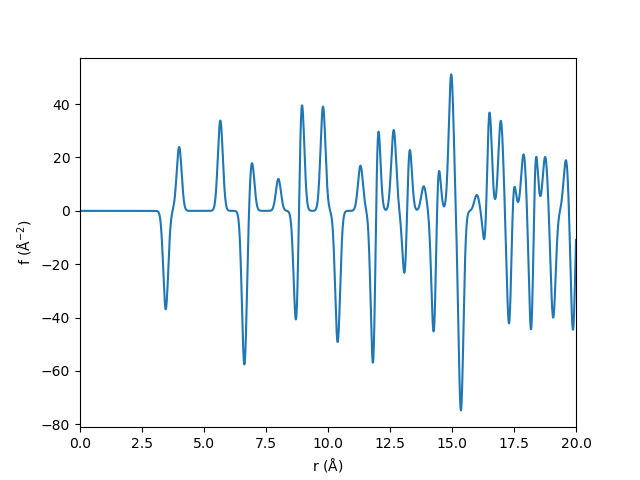

In [16]:
### Now we can set up the MPDFcalculator and plot the mPDF.
mc = MPDFcalculator(mstruc)
mc.plot()

In [17]:
plt.close('all')

# Creating a magnetic structure with multiple species: Simple ferrimagnet

We will create a ferrimagnetic structure to illustrate the use of multiple magnetic species within a single magnetic structure. Let's build another antiferromagnetic body-centered cubic structure but with two different spin species, one with a large moment and one with a small moment.

### Make a magnetic species with a large moment

In [18]:
### Create the first magnetic species and turn off the diffpy.structure option.
mspec1 = MagSpecies(useDiffpyStruc=False)

### Define the lattice vectors of the unit cell. Let's make a cubic unit cell.
a = 4.0
mspec1.latVecs = np.array([[a,0,0],[0,a,0],[0,0,a]])

### Define the atomic position and magnetic moment.
mspec1.atomBasis = np.array([0,0,0])
mspec1.spinBasis = np.array([0,0,1])
### if you have multiple species, they must have distinct labels. A random hex
### string is generated by default, but you can also set your own label.
mspec1.label = 'big'

### Make a magnetic species with a small moment

In [19]:
### Now make the other species, starting with mspec1 as a template
mspec2 = mspec1.copy()
mspec2.atomBasis = np.array([0.5,0.5,0.5])
mspec2.spinBasis = np.array([0,0,-0.5])
mspec2.label = 'small'

### Create and view the magnetic structure

Since you are not using a diffpy Structure object,
the spins are generated from the makeAtoms() method.
Please call that method if you have not already.
Since you are not using a diffpy Structure object,
the spins are generated from the makeAtoms() method.
Please call that method if you have not already.
No magnetic form factor found for that element/ion.
Using generic magnetic form factor.
No magnetic form factor found for that element/ion.
Using generic magnetic form factor.


<IPython.core.display.Javascript object>


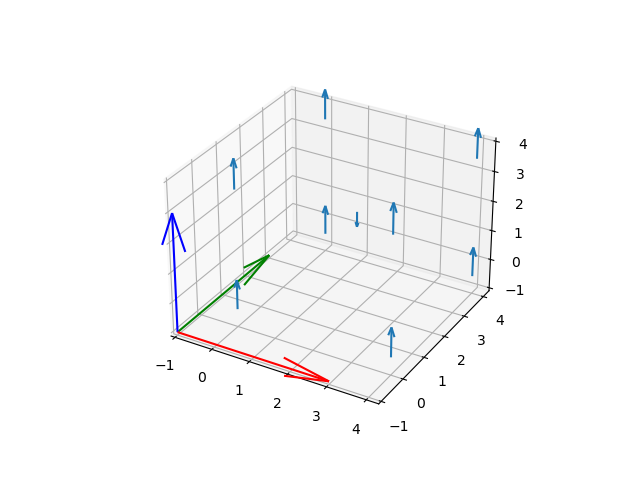

In [20]:
### Create the magnetic structure object and load the species.
mstruc = MagStructure()
mstruc.loadSpecies(mspec1)
mstruc.loadSpecies(mspec2)
mstruc.makeAll()
### Note: when multiple MagSpecies are loaded into a MagStructure using the makeAll()
### command, the calcIdxs attribute of the MagStructure is automatically updated to
### include one spin from each distinct species.

### Again, let's visualize the first unit cell to make sure we have what we expect.
visAtoms = np.array([[0,0,0],[a,0,0],[0,a,0],[0,0,a],[a,a,0],[a,0,a],[0,a,a],[a,a,a],[0.5*a,0.5*a,0.5*a]])
visSpins = mstruc.spinsFromAtoms(visAtoms, fractional=False)
mstruc.visualize(visAtoms, visSpins, showcrystalaxes=True, axesorigin=np.array([-1,-1,-1]))

### Calculate the mPDF

<IPython.core.display.Javascript object>


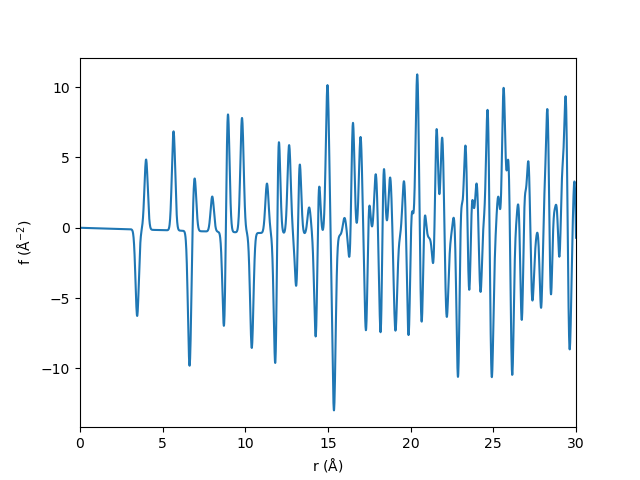

In [21]:
### Now we can set up the MPDFcalculator and plot the mPDF.
mc = MPDFcalculator(mstruc, rmax=30)
mc.plot(linearTermMethod='autoslope')
# Note: we use the linearTermMethod argument for magnetic structures
# with a net magnetization, such as this ferrimagnet.

In [22]:
plt.close('all')

## Creating more complex magnetic structures: One-dimensional spin helix

This example shows how to use multiple magnetic propagation vectors to create a non-collinear magnetic structure--in this case, a one-dimensional spin helix.

<IPython.core.display.Javascript object>


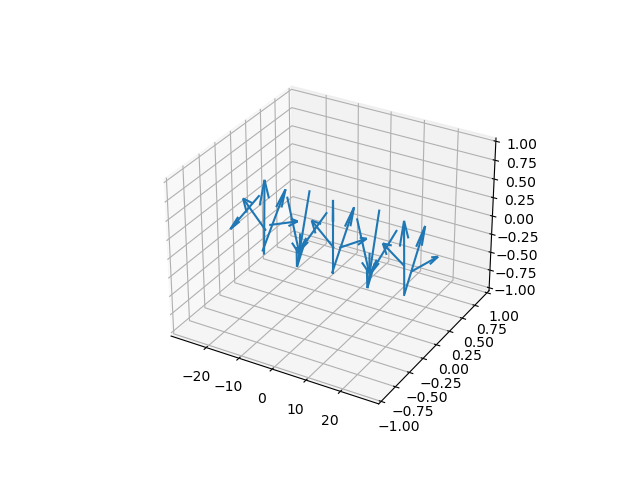

In [23]:
### We will load in a structure from a CIF file and modify it to simulate a 1-D material.
astruc = loadStructure("MnO_cubic.cif")
astruc.lattice.a = 3.0
astruc.lattice.b = 150.0
astruc.lattice.c = 150.0

### Create the magnetic species object.
helix = MagSpecies(astruc)

### Set up the magnetic propagation and basis vectors for a helical spin configuration.
k = np.array([np.sqrt(2)/10,0,0]) # make the period incommensurate with the lattice
helix.kvecs=np.array([k, -k])

Sk = 0.5*(np.array([0,0,1])+0.5j*np.array([0,1,0])) # j is the numpy symbol for the imaginary unit
helix.basisvecs = np.array([Sk,Sk.conj()])

### Populate with atoms and spins.
helix.rmaxAtoms = 70.0 # we will generate spins within a sphere of radius 70 A
helix.makeAtoms()
helix.makeSpins()
helix.label = 'helix'

### Create the magnetic structure object.
mstruc = MagStructure()
mstruc.loadSpecies(helix)

#### Visualize the spins.
x,y,z = mstruc.atoms.transpose()
mask = np.logical_and(z==0,np.logical_and(y==0,np.abs(x)<30))
visatoms = mstruc.atoms[mask]
visspins = spinsFromAtoms(mstruc, visatoms, fractional=False)
mstruc.visualize(visatoms, visspins)

<IPython.core.display.Javascript object>


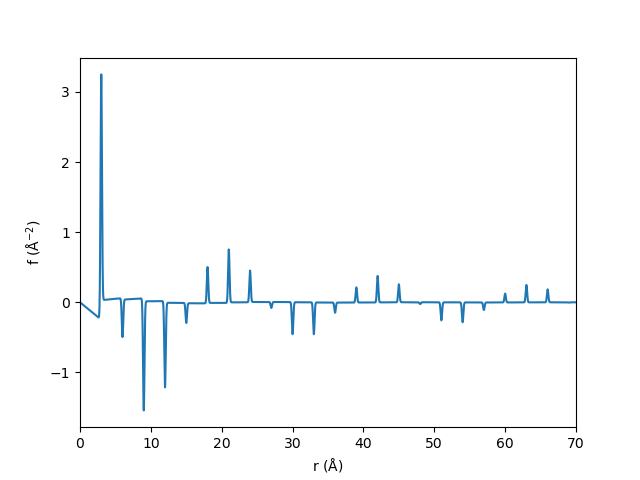

In [24]:
### Now plot the mPDF.
mc = MPDFcalculator(mstruc)
mc.rmax=70.0

mc.plot()

In [25]:
plt.close('all')

## Exploring some of the additional parameters in the mPDF

Now we will take a look at some of the other aspects of the mPDF that can be adjusted, including:
- Whether the normalized (i.e. deconvoluted) mPDF, unnormalized (i.e. non-deconvoluted) mPDF, or both are calculated (see Frandsen & Billinge, Acta Cryst. A71 (2015), 325-334; 
https://doi.org/10.1107/S205327331500306X
).
- Qmax to simulate experimental conditions.
- Parameters that dampen and/or broaden the mPDF, simulating the effects of thermal motion and instrumental resolution.
- "Ordered" scale factor corresponding to the magnitude of the locally ordered moment, and "paramagnetic" scale factor which depends only on the magnitude and spatial extent of a single localized moment, not any correlations between moments.
- The r-range for the calculation.

For this, we will create the antiferromagnetic MnO structure again.

### Create the MnO magnetic structure

In [26]:
### Create the MagStructure object and populate the atom/spin arrays.
### Feel free to copy and paste from before.
mstruc = create_from_mcif('1.31_MnO.mcif', ffparamkey='Mn2')
mstruc.makeAll()

MagStructure creation from mcif file successful.


### Calculate the normalized and unnormalized mPDFs

<IPython.core.display.Javascript object>


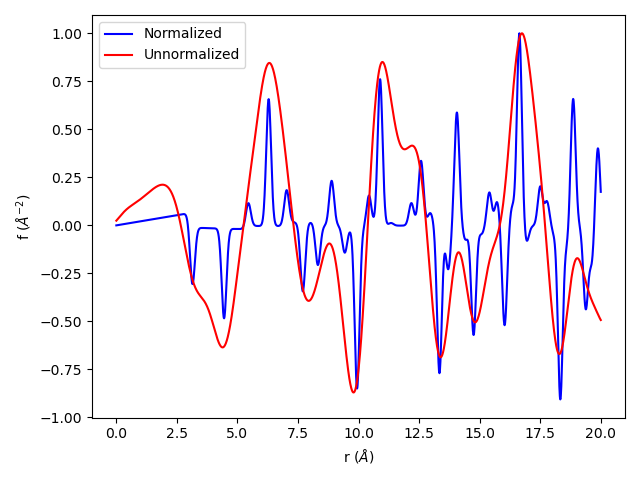

In [27]:
mc = MPDFcalculator(mstruc)
r, fr = mc.calc() ### by default, just the normalized mPDF is calculated
r, dr = mc.calc(normalized=False) ### setting the normalized arg to False calculates the unnormalized mPDF

### Let's compare the two quantities

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr/fr.max(), 'b-', label='Normalized')
ax.plot(r, dr/dr.max(), 'r-', label='Unnormalized')

ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Or you can calculate them both together:
r, fr, dr = mc.calc(both=True)

### Model the effect of finite Qmax

<IPython.core.display.Javascript object>


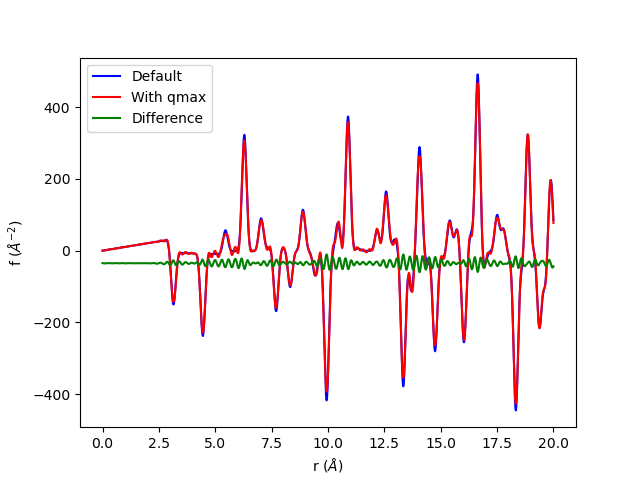

In [28]:
### Default mPDF calculator
mc = MPDFcalculator(mstruc)
r, fr = mc.calc()

### Adjust qmax to simulate termination ripples
mcA = mc.copy()
mcA.qmax = 20
rA,frA = mcA.calc()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr, 'b-', label='Default')
ax.plot(rA, frA, 'r-', label='With qmax')
ax.plot(r, frA-fr-35, 'g-', label='Difference')

ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

### Change the intrinisic mPDF peak width

<IPython.core.display.Javascript object>


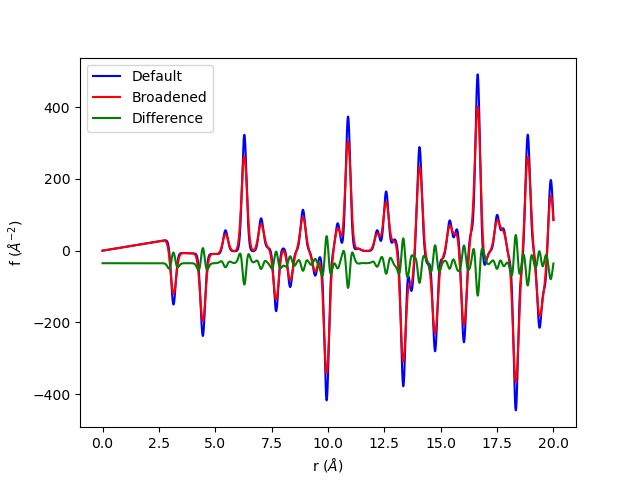

In [29]:
### Change the intrinsic mPDF peak width to simulate thermal motion
mcB = mc.copy()
mstrucB = mstruc.copy()
mstrucB.Uiso = 0.015 # atomic displacement parameter; default is 0.01
mcB.magstruc = mstrucB
rB, frB = mcB.calc()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr, 'b-', label='Default')
ax.plot(rB, frB, 'r-', label='Broadened')
ax.plot(r,frB - fr - 35, 'g-', label='Difference')
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

### Implement a finite correlation length

<IPython.core.display.Javascript object>


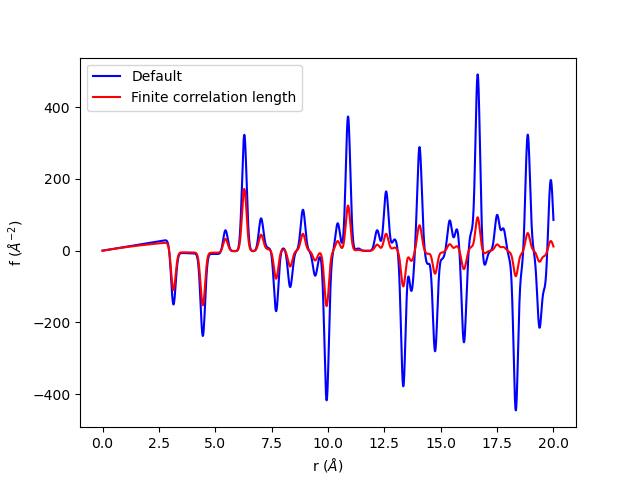

In [30]:
### Include a damping factor to simulate a finite correlation length
### and/or instrumental resolution effects.
mcC = mc.copy()
mstrucC = mstruc.copy()
mstrucC.corrLength = 10 # correlation length in Angstroms
mcC.magstruc = mstrucC
rC, frC = mcC.calc()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr, 'b-', label='Default')
ax.plot(rC, frC, 'r-', label='Finite correlation length')
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

### Change the ordered scale factor

<IPython.core.display.Javascript object>


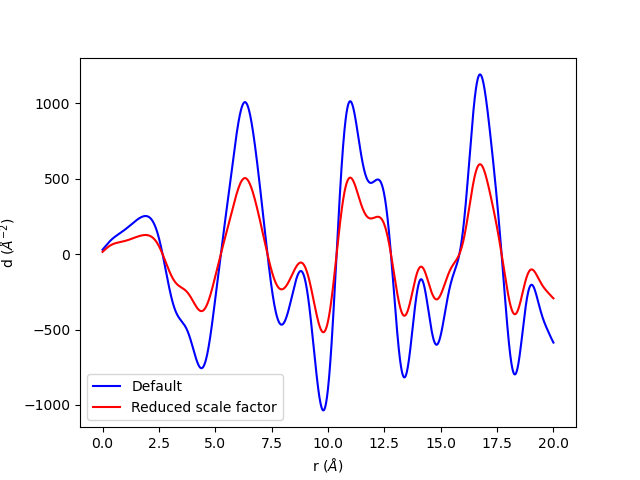

In [31]:
### Reduce the ordered scale factor, simulating a reduced ordered moment.
mcD = mc.copy()
mcD.ordScale = 0.5*mc.ordScale
rD, frD, drD = mcD.calc(both=True) # both the normalized and unnormalized mPDF

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, dr, 'b-', label='Default')
ax.plot(rD, drD, 'r-', label='Reduced scale factor')
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'd ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

### Change the calculation range

MagStructure creation from mcif file successful.


<IPython.core.display.Javascript object>


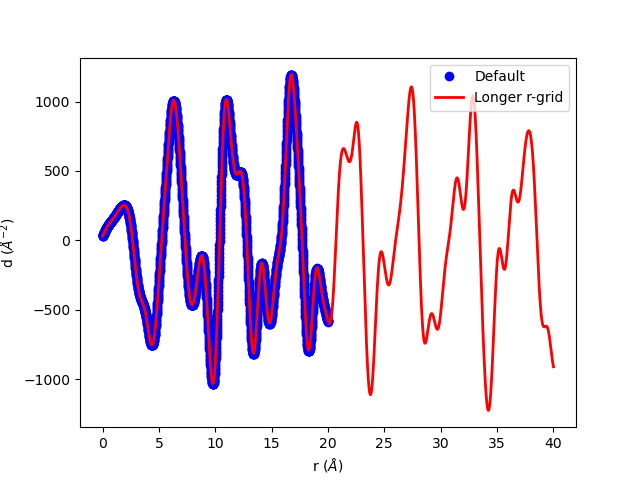

In [33]:
### Since the r-range is longer, we also need to re-generate the atoms and spins
### to fill a sphere of at least radius 40 Angstroms. The code below does this.
### See what happens if you set rmaxAtoms to something too small, like 10 or 15.
mcif = '1.31_MnO.mcif'
mstruc = create_from_mcif(mcif, ffparamkey='Mn2', rmaxAtoms=40)
mstruc.makeAll()

### Change the r-range for the calculation from 20 Angstroms (default) to 40.
mcE = MPDFcalculator(mstruc)
mcE.rmax = 40 # in Angstroms


rE,frE,drE = mcE.calc(both=True)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, dr, 'bo', label='Default')
ax.plot(rE, drE, 'r-', label='Longer r-grid',lw=2)
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'd ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

In [34]:
plt.close('all')